# Tools for Analytics - Session 002
## Final Project
## Group 23333

Group Members: Ariel Liu, Yuqin Wang, Zihao Wang, Huanlun Li
Starting Date: 11.21.18

Our Project is mainly targeting on Twitter Crawling, allowing users to give in user input for specific tweet
searches. We will make a word map according to the frequencies of words the user chooses to post in his/her recent
tweets. We will input President Donald Trump's user ID as a demo in the end of our project.

Code Function 1: download all tweets into a csv file

In [1]:
# NOTICE: Plz use "pip install tweepy" to install the newest tweepy in your VM first
# load all necessary libraries
# first pip install . is needed to import packages below in vm

# we use utf-8 -*-
import tweepy
import csv
import nltk
from nltk.corpus import stopwords
import wordcloud
import numpy as np
import pandas as pd
import re
import csv
# wordcloud can be a little tricky to install. We want to mask the cloud into any shape of your choice 
# This requires a different method from a user from github to install:
# git clone https://github.com/amueller/word_cloud.git
# cd word_cloud
# pip install .
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from os import path
from PIL import Image

# APIs from dev environment
## Four keys here: consumer key, consumer key secret, access key, access key secret
ckey = '34jYgpQ3kswuFlA4nYNKgfJjr' 
ckey_secret = 'FJTyCCzlcVScDocOCNc3omEAVXD4ZpMppiJ3ufamVmXqd2wjeD'
akey = '1034815350821593098-U0VnXpnIUtgFgcU1KmvZmpfnkYjPyL'
akey_secret = '3M7zM2PJCUcbAChK48r1NrmlAn7h03wZwIMjehHaww34N'

# define a new var for export the user name to other method
exp_user_name = ''


# for bold text
bold = "\033[1m"
reset = "\033[0;0m"

def get_tweets(user_name):
    
    # Use Tweepy package to do authentication
    aut = tweepy.OAuthHandler(ckey, ckey_secret)
    aut.set_access_token(akey, akey_secret)
    api = tweepy.API(aut)
    
    # define a tweet holder
    tweets_holder = []
    
    # Hold incoming new tweets, 500 tweets each time
    add_in_tweets = api.user_timeline(screen_name=user_name, count = 500, tweet_mode = 'extended')
        
    # If the twitter account has no tweet, let the user try another account
    # put bold-text warning!
    if add_in_tweets == []:
        print(bold + "Attention: This twitter user has no tweet in history, please try another one." + reset)
        return get_tweets(input("Input the username(e.g. @xxxxx) whose tweets you wanna see: "))
    
    # Put all tweets into the holder
    tweets_holder.extend(add_in_tweets)

    
    oldest = tweets_holder[-1].id - 1

    # Keep getting tweets until there's nothing left

    while len(add_in_tweets) > 0:
        
        # We set the maximum equal to the oldest tweet to avoid duplication
        
        add_in_tweets = api.user_timeline(screen_name=user_name, count = 500, max_id = oldest, tweet_mode = 'extended')

        # Extend tweets holder to save the new tweets

        tweets_holder.extend(add_in_tweets)

        # Update the oldest tweet

        oldest = tweets_holder[-1].id - 1
        print (bold + 'Completed downloading %s number of tweets' % len(tweets_holder) + reset)
        
        # transforming all tweets into a list of lists
    output = [[tweet.id_str, tweet.full_text.encode('utf-8'), tweet.created_at] for tweet in tweets_holder]
    
    # export the user_name var for using in other methods 
    
    global exp_user_name
    exp_user_name = user_name
    
    # writing the list into the csv
    
    with open(user_name + '_tweets_history.csv', 'w', encoding='utf8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['ID','Content', 'Create Time'])
        writer.writerows(output)
            
if __name__ == '__main__':

    # Enter the username
    # The username is followed by '@'. You should include '@'. For example, President Donald Trump's
    # username is: @realDonaldTrump  @elonmusk

    get_tweets(input("Input the username(e.g. @xxxxx) whose tweets you wanna see: "))
    

Input the username(e.g. @xxxxx) whose tweets you wanna see: @realDonaldTrump
Completed downloading 400 number of tweets
Completed downloading 599 number of tweets
Completed downloading 797 number of tweets
Completed downloading 993 number of tweets
Completed downloading 1193 number of tweets
Completed downloading 1393 number of tweets
Completed downloading 1593 number of tweets
Completed downloading 1793 number of tweets
Completed downloading 1993 number of tweets
Completed downloading 2193 number of tweets
Completed downloading 2393 number of tweets
Completed downloading 2593 number of tweets
Completed downloading 2793 number of tweets
Completed downloading 2993 number of tweets
Completed downloading 3193 number of tweets
Completed downloading 3215 number of tweets
Completed downloading 3215 number of tweets


Code Function 2: Cleaning up all the tweets by getting rid of special marks, etc

In [2]:
# csv file cleaning up
# get any column of contents from the csv file

# need to modify file name to be user defined
with open(exp_user_name + '_tweets_history.csv', 'r', encoding='utf8') as fp:
    # read the file as a dictionary for each row ({header : value})
    reader = csv.DictReader(fp)
    data = {}
    for row in reader:
        for header, value in row.items():
            try:
                data[header].append(value)
            except KeyError:
                data[header] = [value]


#csv header as "ID,Content,Create Time"
twitter_ID = data["ID"]
twitter_content = data["Content"]
twitter_time = data["Create Time"]

In [3]:
# Code below is to separete each word and convert all words like "text233lol!?", "TEXT233lol", "TeXt233lol" into "text233lol"
# a word_list is created includes all the words in content

pattern = r'\w+'                # Separate words and extract them without symbols like .,!?''""
remove_exp_pattern = r'\\[a-zA-Z0-9_]+'    #  match word like "\\xe2"
remove_start_pattern = r"b'"    # match word like b'
remove_amp_pattern = r'&amp;'    # match word like &amp;
remove_weblink_pattern = r'https(\S+)+'      # match word like https://t.co/Zg15gmPazF
remove_retweet_pattern = r'RT'  # match word 'rt'(means: retweet). This will be noticeable in the map if not removed
remove_username_pattern = r'@[a-zA-Z0-9_]+'  #remove username words such as '@realDonaldTrump or @washingtonpost'
word_list = []

for content_row in range(len(twitter_content)):
    
    # Remove specific patterns
    
    twitter_content[content_row] = re.sub(remove_weblink_pattern, ' ', twitter_content[content_row])
    #print(twitter_content[content_row])
    twitter_content[content_row] = re.sub(remove_exp_pattern, ' ', twitter_content[content_row])
    twitter_content[content_row] = re.sub(remove_amp_pattern, ' ', twitter_content[content_row])
    twitter_content[content_row] = re.sub(remove_start_pattern, ' ', twitter_content[content_row])
    twitter_content[content_row] = re.sub(remove_retweet_pattern, ' ', twitter_content[content_row])
    twitter_content[content_row] = re.sub(remove_username_pattern, ' ', twitter_content[content_row])
    #print(twitter_content[content_row])
    
    # Find remaining word without symbols and append them into a nested list
    
    match = re.findall(pattern, twitter_content[content_row])
    match = [x.lower() for x in match]
    word_list.append(match)

# flatten the word_list

flattened_word_list = [val for sublist in word_list for val in sublist]
# wrap back into a clean text file

content = """"""
for items in flattened_word_list:
    content += items+" "


Code Function 3: Visulizing the result by generating a wordmap

Enter 1 for Regular Wordmap;
Enter 2 for US Flag Wordmap;
Enter 3 for Love&Peace Wordmap.
Input specific wordmap style you want: 3
It may spend few seconds to produce the wordmap, plz wait...


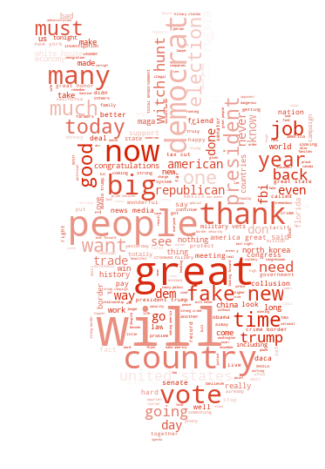

In [4]:
# method for showing the flag shaped image  
def show_image(text, choice):
    # Define mask
    # set stopword list
    flag_us_mask = np.array(Image.open("Pictures/USflag.png"))
    flag_lovenpeace=np.array(Image.open("Pictures/lovenpeace.png"))

    # choose regular shape
    if choice == "1":
        wordmap = WordCloud().generate(text)
        plt.imshow(wordmap,interpolation="bilinear")
    # flag shape
    elif choice == "2":
        print(bold+"It may spend few seconds to produce the wordmap, plz wait..."+reset)
        wordcloud_us = WordCloud(background_color="white", 
                             mode="RGBA", max_words=1000, mask=flag_us_mask).generate(text) 
        image_colors = wordcloud.ImageColorGenerator(flag_us_mask)
        plt.figure(figsize=(10,8))
        plt.imshow(wordcloud_us.recolor(color_func=image_colors), interpolation="bilinear")
    # choose love and peace shape
    elif choice == "3":
        print(bold+"It may spend few seconds to produce the wordmap, plz wait..."+reset)
        wordcloud_lovenpeace = WordCloud(background_color="white", 
                             mode="RGBA", max_words=1000, mask=flag_lovenpeace).generate(text) 
        image_colors = wordcloud.ImageColorGenerator(flag_lovenpeace)
        plt.figure(figsize=(10,8))
        plt.imshow(wordcloud_lovenpeace.recolor(color_func=image_colors), interpolation="bilinear") 
    # Let user re-enter when the word entered is not recognized
    else:
        print(bold+"Attention: Plz enter 1 or 2 or 3!"+reset)
        return show_image(content, input(bold+"Enter 1 for Regular Wordmap;\nEnter 2 for US Flag Wordmap;\nEnter 3 for Love&Peace Wordmap.\n"
                         +reset+'''Input specific wordmap style you want: '''))
        
    plt.axis("off")
    plt.show()

# Output
show_image(content, input(bold+"Enter 1 for Regular Wordmap;\nEnter 2 for US Flag Wordmap;\nEnter 3 for Love&Peace Wordmap.\n"
                         +reset+'''Input specific wordmap style you want: '''))

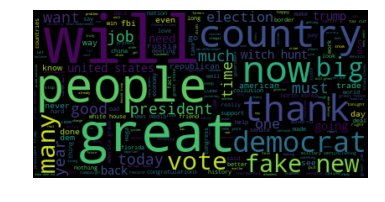

In [5]:
### Cells below are all examples
show_image(content,"1")

It may spend few seconds to produce the wordmap, plz wait...


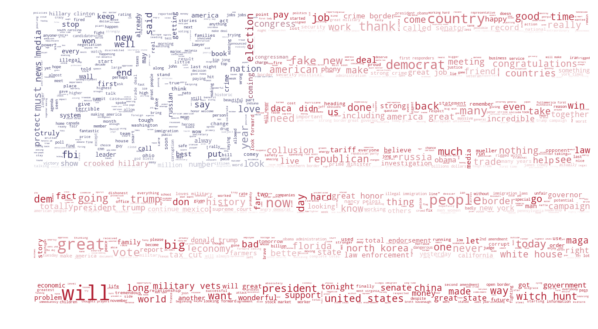

In [6]:
show_image(content,"2")

It may spend few seconds to produce the wordmap, plz wait...


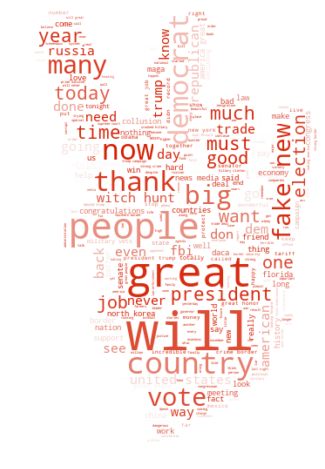

In [7]:
show_image(content,"3")